In [2]:
# Standard imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from ieeg.auth import Session
from scipy import signal as sig
from scipy.integrate import simpson
from scipy.signal import coherence
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize

import scipy as sc
from bct.algorithms import community_louvain
plt.rcParams['image.cmap'] = 'BuPu'

# ML Imports
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF,ConstantKernel
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF
from sklearn.utils import resample

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
import pathlib
from tqdm import tqdm
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')
import mne

import os
os.environ["ETS_TOOLKIT"] = "qt4"
os.environ["QT_API"] = "pyqt5"

## Data Loading

In [3]:
metadata = pd.read_csv('../metadata_wchreject.csv')
# (metadata.cceps_hfs_seizure == 1) | 
metadata = metadata[(metadata.cceps_run1_sz == 1)].reset_index()
metadata.loc[:,'ieeg_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_phaseII'
metadata.loc[:,'ccep_id'] = 'HUP' + metadata.hupsubjno.apply(str) + '_CCEP'

In [4]:
with open('config.json','r') as f:
    CONFIG = json.load(f)
usr = CONFIG["paths"]["iEEG_USR"]
passpath = CONFIG["paths"]["iEEG_PWD"]
datapath = CONFIG["paths"]["RAW_DATA"]
prodatapath = CONFIG["paths"]["PROCESSED_DATA"]
ieeg_list = CONFIG["patients"]
rid_hup = pd.read_csv(ospj(datapath,'rid_hup.csv'))
pt_list = np.unique(np.array([i.split("_")[0] for i in ieeg_list]))

In [5]:
pt = "HUP235"
raw_datapath = ospj(datapath,pt)


In [6]:
dirty_drop_electrodes = metadata[metadata.hupsubjno == int(pt[-3:])]["final_reject_channels"].str.split(',').to_list()[0]
if isinstance(dirty_drop_electrodes,list):
        final_drop_electrodes = clean_labels(dirty_drop_electrodes,pt)
else:
    final_drop_electrodes = []

In [7]:
seizure_list = np.sort([s for s in os.listdir(ospj(raw_datapath, "seizures")) if 'preprocessed' in s])

In [8]:
all_seizures = []
all_ts = []
for seizure_path in seizure_list:
    seizure_fs = pd.read_pickle(ospj(raw_datapath,"seizures",seizure_path))
    fs = seizure_fs.fs.to_numpy()[-1]
    seizure = seizure_fs.drop("fs",axis=1)
    cols = seizure.columns.to_list()
    clean_ch = [c for c in cols if c not in final_drop_electrodes]
    seizure = seizure.loc[:,clean_ch]
    t = np.arange(0,len(seizure)/fs,1/fs)
    all_ts.append(t)
    all_seizures.append(seizure)
    # plot_iEEG_data(seizure,t)


### Sandboxing DTW

(<Figure size 616.536x1440 with 1 Axes>, <Axes: xlabel='Time (s)'>)

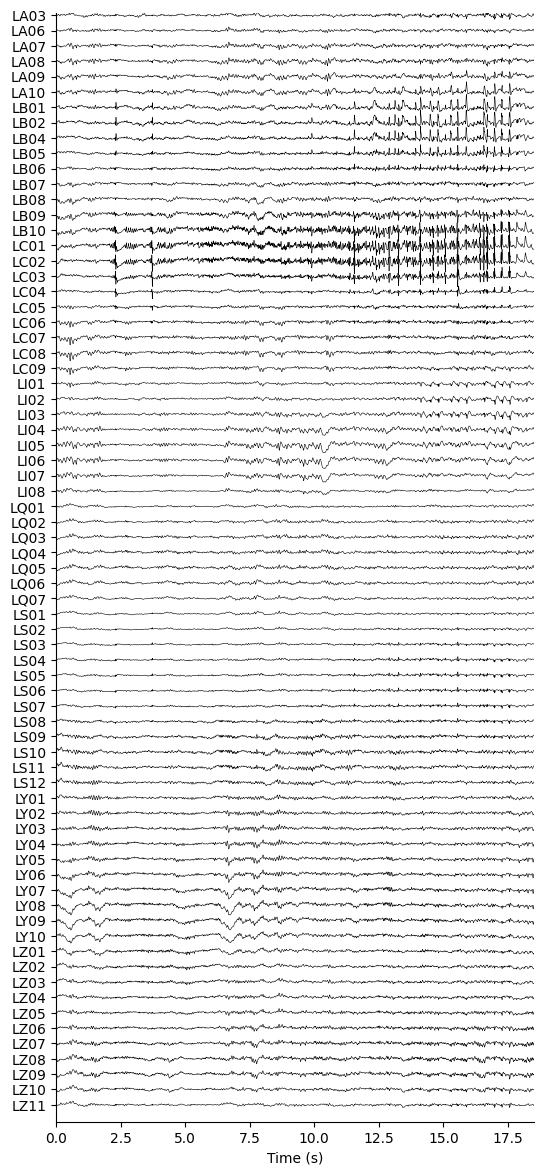

In [80]:
s = 3
plot_iEEG_data(all_seizures[s],all_ts[s])

#### Data Generation

In [33]:
factor = 2

data = all_seizures[1]
data = sig.decimate(data,factor,axis=0)
data = pd.DataFrame(data,columns=all_seizures[1].columns)
nfs = fs/factor

# Simulate a DataFrame
n_channels = data.shape[1]
m_samples = data.shape[0]

# Define frequency bands
freq_bands = [(1, 4), (4, 8), (8, 13), (13, 30), (30, 80), (80, 150)]

# Window parameters
window_length = int(10 * nfs)
stride = int(nfs)

# Initialize lists to hold results
all_coherences = []

# Loop through each window
for start in tqdm(range(0, m_samples - window_length + 1, stride)):
    window_data = data.iloc[start:start + window_length]
    coherence_matrix_list = []
    
    for low_f, high_f in freq_bands:
        coherences = []
        for i in range(n_channels):
            for j in range(i+1, n_channels):
                f, Cxy = coherence(window_data.iloc[:, i], window_data.iloc[:, j], fs=fs)
                avg_coh = np.mean(Cxy[(f >= low_f) & (f <= high_f)])
                coherences.append(avg_coh)
        
        coherence_matrix_list.append(np.array(coherences))
    
    concatenated_coherence = np.concatenate(coherence_matrix_list)
    all_coherences.append(concatenated_coherence)
print('coh done')
# Convert to NumPy array and L1 normalize
all_coherences = np.array(all_coherences)
all_coherences = normalize(all_coherences, norm='l1', axis=1)


100%|██████████| 123/123 [29:17<00:00, 14.29s/it]


coh done


#### Data Analysis

In [9]:
# with open(ospj(prodatapath,'all_coh_test.pkl'),'wb') as f:
#     pickle.dump(all_coherences,f)
with open(ospj(prodatapath,'all_coh_test.pkl'),'rb') as f:
    all_coherences = pickle.load(f)

In [47]:
# Stability-based NMF
n_bootstrap = 1e1  # Number of bootstrap samples
max_components = 10  # Maximum number of components to test
stability_scores = []

for k in tqdm(range(1, max_components + 1)):
    W_list = []
    
    for _ in range(int(n_bootstrap)):
        # Bootstrap resampling
        bootstrap_data = resample(all_coherences)
        
        # Perform NMF on bootstrap sample
        model = NMF(n_components=k, init='random', random_state=0)
        W = model.fit_transform(bootstrap_data)
        
        # Sort each component by size and store
        W_list.append(np.sort(W, axis=0))
        
    # Calculate stability score across bootstrap samples
    W_array = np.array(W_list)
    stability_score = np.mean(np.std(W_array, axis=0) / np.mean(W_array, axis=0))
    stability_scores.append(stability_score)

# Identify the number of components that gives the minimum stability score
optimal_k = np.argmin(stability_scores) + 1

# Perform NMF with optimal number of components
model = NMF(n_components=optimal_k, init='random', random_state=0)
W_optimal = model.fit_transform(all_coherences)
H_optimal = model.components_

100%|██████████| 10/10 [16:21<00:00, 98.18s/it] 


In [49]:
optimal_k

3

In [74]:
def sammon(X, max_iter=1e10, tol=1e-9):
    pairwise_dissimilarities = squareform(pdist(X, metric='cityblock'))  # Using L1 distance
    # plt.imshow(pairwise_dissimilarities)
    init = np.random.rand(X.shape[0], 2)  # Random 2D initialization
    
    def stress(Y):
        Y = Y.reshape((X.shape[0], 2))
        d = squareform(pdist(Y))
        d[d == 0] = 1  # Prevent division by zero
        ratio = pairwise_dissimilarities / d
        return np.sum((pairwise_dissimilarities - d)**2 * ratio)
    
    res = minimize(stress, init.ravel(), method='L-BFGS-B', tol=tol, options={'maxiter': max_iter, 'disp': True})
    return res.x.reshape((X.shape[0], 2))


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          246     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80867D+02    |proj g|=  3.02249D+03

At iterate    1    f=  8.96823D+02    |proj g|=  3.58567D+02

At iterate    2    f=  8.54845D+02    |proj g|=  1.65901D+02

At iterate    3    f=  8.23977D+02    |proj g|=  7.52798D+01

At iterate    4    f=  7.59943D+02    |proj g|=  7.16512D+01

At iterate    5    f=  6.85663D+02    |proj g|=  1.65976D+02

At iterate    6    f=  6.62139D+02    |proj g|=  1.29169D+02

At iterate    7    f=  6.33242D+02    |proj g|=  5.40784D+01


 This problem is unconstrained.



At iterate    8    f=  5.77566D+02    |proj g|=  3.76271D+02

At iterate    9    f=  5.62665D+02    |proj g|=  5.44755D+01

At iterate   10    f=  5.48341D+02    |proj g|=  9.39252D+01

At iterate   11    f=  5.28099D+02    |proj g|=  2.08233D+02

At iterate   12    f=  5.05758D+02    |proj g|=  5.85145D+01

At iterate   13    f=  4.81595D+02    |proj g|=  5.08937D+01

At iterate   14    f=  4.44342D+02    |proj g|=  2.12682D+03

At iterate   15    f=  4.41151D+02    |proj g|=  2.61601D+02

At iterate   16    f=  4.37419D+02    |proj g|=  1.27856D+02

At iterate   17    f=  4.32596D+02    |proj g|=  2.57896D+02

At iterate   18    f=  4.17277D+02    |proj g|=  9.35878D+01

At iterate   19    f=  4.11276D+02    |proj g|=  6.23390D+01

At iterate   20    f=  3.98561D+02    |proj g|=  3.88965D+01

At iterate   21    f=  3.91948D+02    |proj g|=  1.88109D+02

At iterate   22    f=  3.65872D+02    |proj g|=  1.22127D+02

At iterate   23    f=  3.55189D+02    |proj g|=  4.89157D+01

At iter

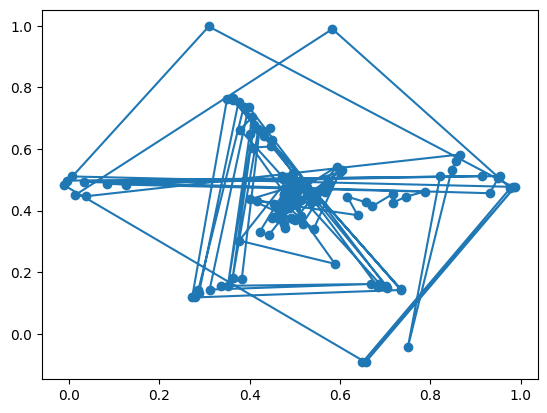

In [75]:
embeddings = sammon(recon_cohs)
plt.figure()
plt.plot(embeddings[:,0],embeddings[:,1],'o-')

### Electrode Agreement

In [8]:
hup_no = pt[3:]
rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
recon_path =  ospj('/mnt','leif','littlab','data',
                        'Human_Data','recon','BIDS_penn',
                        f'sub-RID0{rid}','derivatives','ieeg_recon',
                        'module3/')
atropos_metadata = pd.read_json(recon_path + f'sub-RID0{rid}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
atropos_metadata.loc[:,['name']] = clean_labels(atropos_metadata.name,pt)
localization_probs = pd.read_json(recon_path + f'sub-RID0{rid}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
localization_probs.loc[:,['name']] = clean_labels(localization_probs.name,pt)



In [9]:
def _apply_function(x):
    # look in labels sorted and see if it contains gray matter
    # if gray matter is greater than 5% then set label to gray matter
    x = pd.DataFrame(x).transpose()
    for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
        if (label != 'EmptyLabel') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
            x['label'] = label
            continue
        elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
            x['label'] = label
    return x

modified_regions = localization_probs.apply(_apply_function,axis=1)
modified_regions_df = pd.DataFrame(np.squeeze(np.array(modified_regions.to_list())),columns=localization_probs.columns)


In [10]:
soz_ch = clean_labels(['LC1'],pt)
stim_soz_ch = clean_labels(['LI1', 'LI2', 'LA1', 'LA2', 'LB1', 'LB2', 'LB3', 'LB4', 'LC1', 'LC2', 'LC3'],pt)
hf_soz_ch = clean_labels(['LB1','LB2','LB3'],pt)

In [11]:
soz_array = modified_regions_df.name.isin(soz_ch).to_numpy()
stim_soz_array = modified_regions_df.name.isin(stim_soz_ch).to_numpy()
hf_soz_array = modified_regions_df.name.isin(hf_soz_ch).to_numpy()

### Convex Hulls

In [12]:
soz_coords = atropos_metadata.loc[atropos_metadata.name.isin(soz_ch),['x','y','z']]
soz_coords

stim_coords = atropos_metadata.loc[atropos_metadata.name.isin(stim_soz_ch),['x','y','z']]

hf_soz_coords = atropos_metadata.loc[atropos_metadata.name.isin(soz_ch),['x','y','z']]
hf_soz_coords

,x,y,z
24,67.2158,113.871,137.636


In [11]:
lf_hull = sc.spatial.ConvexHull(stim_coords)
lf_dhull = sc.spatial.Delaunay(stim_coords)
lf_intersect = lf_dhull.find_simplex(soz_coords) >=0

137.636


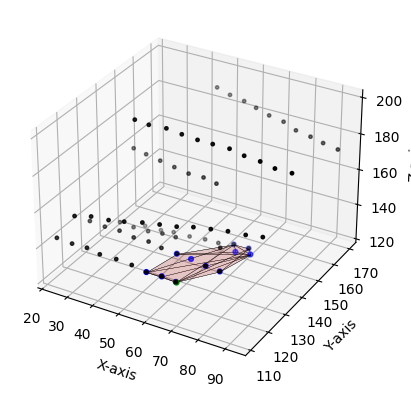

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
points = stim_coords.to_numpy()

# Plot all electrodes
all_contacts = atropos_metadata.loc[atropos_metadata.name.isin(clean_ch),['x','y','z']].to_numpy()
ax.scatter(all_contacts[:,0],all_contacts[:,1],all_contacts[:,2],"o",color="k",s=6)

# Plot the points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], "o", color="b", s=12)

# Plot the convex hull's facets
for simplex in lf_hull.simplices:
    polygon = [lf_hull.points[i] for i in simplex]
    poly3d = [[vert[ix] for vert in polygon] for ix in range(3)]
    ax.plot_trisurf(*poly3d, color='r',edgecolor='k',linewidth=.2, alpha=0.1)
coords = soz_coords.to_numpy()[0]
print(coords[2])
ax.scatter(coords[0],coords[1],coords[2],"o",color='g',s=12)

ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
plt.show()

In [ ]:
dice_score()

In [12]:
# import numpy as np
# from scipy.spatial import ConvexHull
# from nilearn import datasets, surface
# from mayavi import mlab
# # mlab.options.offscreen = True
# # Fetch the fsaverage dataset
# fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage')

# # Load the coordinates (vertices) and triangles (faces) from the mesh files
# coords, faces = surface.load_surf_mesh(fsaverage.pial_left)

# # Display the brain's surface
# mlab.triangular_mesh(coords[:, 0], coords[:, 1], coords[:, 2], faces, color=(0.5, 0.5, 0.5), opacity=0.6)

# # Generate random data points for the convex hull
# points = np.random.rand(30, 3) * 200 - 100  # Adjust these values as needed to position on the brain surface

# # Compute the convex hull of the points
# hull = ConvexHull(points)

# # Plot the convex hull's simplices (triangular facets) on top of the brain surface
# mlab.triangular_mesh(points[:, 0], points[:, 1], points[:, 2], hull.simplices, color=(1, 0, 0))

# # Display the visualization
# # mlab.show()

# img = mlab.screenshot()
# plt.imshow(img)
# plt.axis('off')
# plt.show()


### Seizure Plotting

In [16]:
def nonstationary_bandpower(x: np.ndarray, fs: float, lo_stop=1, hi_stop=120, relative=True, win_size=2, win_stride=1) -> np.array:
    """
    Calculates the relative bandpower of a signal x, using a butterworth filter of order 'order'
    and bandpass filter between lo and hi Hz.

    Use scipy.signal.welch and scipy.integrate.simpson
    """
    
    bands = {"delta": (1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}
    bands = {"broad": (6,100)}
    nperseg = int(win_size * fs)
    noverlap = nperseg - int(win_stride * fs)

    # freq, pxx = sig.welch(x=x, fs=fs, nperseg=nperseg, noverlap=noverlap, axis=1)
    freq,t,Sxx = sig.spectrogram(x=x,fs=fs,nperseg=nperseg,noverlap=noverlap,axis=1)
    filter_idxs = (freq > lo_stop) & (freq < hi_stop)
    # log transform the power spectrum
    # pxx = 10*np.log10(pxx)
    
    all_bands = np.zeros((Sxx.shape[0],len(bands),Sxx.shape[2]))
    for i, (_, (lo, hi)) in enumerate(bands.items()):
        idx_band = np.logical_and(freq >= lo, freq <= hi)
        bp = simpson(Sxx[:, idx_band,:], dx=freq[1] - freq[0],axis=1)
        # relative
        if relative:
            bp /= simpson(Sxx[:,filter_idxs,:], dx=freq[1] - freq[0],axis=1)
        all_bands[:, i,:] = bp
    return all_bands,t
    # return bp
    # return data_filt
bp = nonstationary_bandpower(seizure.to_numpy().T,fs)

In [17]:
bp.shape

(72, 1, 94)

In [18]:
seizure_signals,_ = [nonstationary_bandpower(x.T,fs,win_size=1,win_stride=.5,relative=True).squeeze() for x in all_seizures];

In [85]:
n1 = 1
n2 = 1
s1 = seizure_signals[n1]
t1 = all_ts[n1]
s2 = seizure_signals[n2]
t2 = all_ts[n2]
seizure_comparison = np.zeros((seizure_signals[n1].shape[1],seizure_signals[n2].shape[1]))
for i in range(s1.shape[1]):
    for j in range(s2.shape[1]):
        c = np.corrcoef(s1[:,i],s2[:,j])
        seizure_comparison[i,j] = np.abs(c[0,1]) * (1-0.2*np.abs(i-j)/s1.shape[0])

In [86]:
seizure_comparison.min()

2.5253180874729072e-06

In [91]:
all_ass = []
for s in range(100):
    assignments,_ = community_louvain(seizure_comparison,.9,seed=s)
    all_ass.append(assignments)
all_ass = np.array(all_ass)


In [92]:
raw_assignments,_ = sc.stats.mode(all_ass,axis=0)

In [95]:
filt_assignments = sig.medfilt(raw_assignments,7)

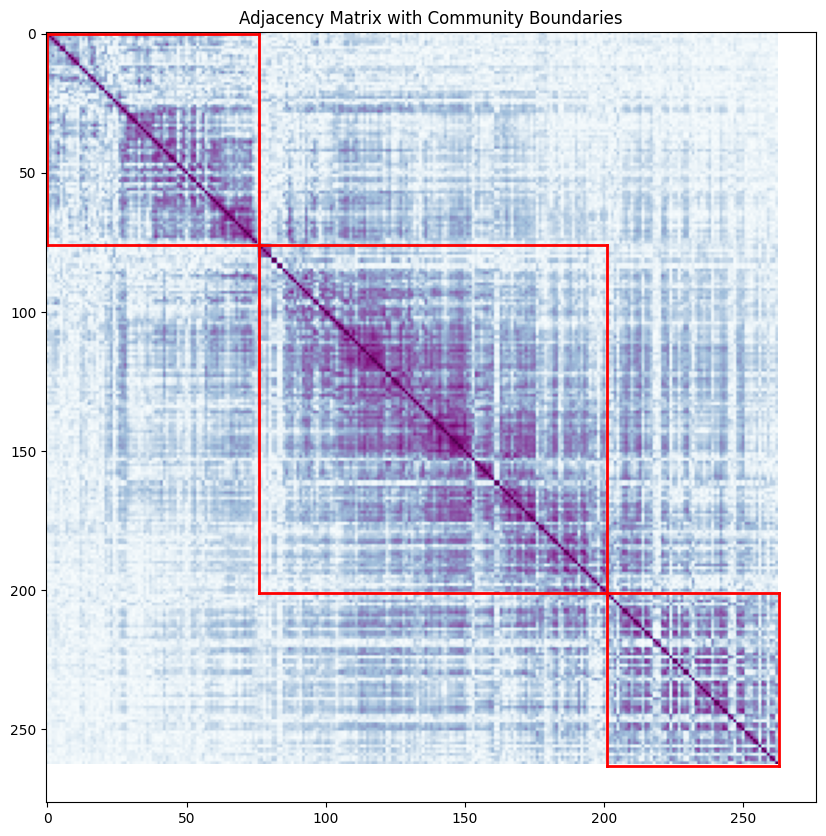

In [98]:
plt.figure(figsize=(10, 10))
order = np.argsort(filt_assignments)

plt.imshow(seizure_comparison)
# Drawing the community boundaries
current_x = 0

for module in np.unique(filt_assignments):
    size = np.sum(filt_assignments[order] == module)
    plt.plot([current_x, current_x + size], [current_x, current_x], 'r', linewidth=2)
    
    # Left boundary
    plt.plot([current_x, current_x], [current_x, current_x + size], 'r', linewidth=2)
    
    # Bottom boundary
    plt.plot([current_x, current_x + size], [current_x + size, current_x + size], 'r', linewidth=2)
    
    # Right boundary
    plt.plot([current_x + size, current_x + size], [current_x, current_x + size], 'r', linewidth=2)
    
    current_x += size


plt.title('Adjacency Matrix with Community Boundaries')
plt.show()


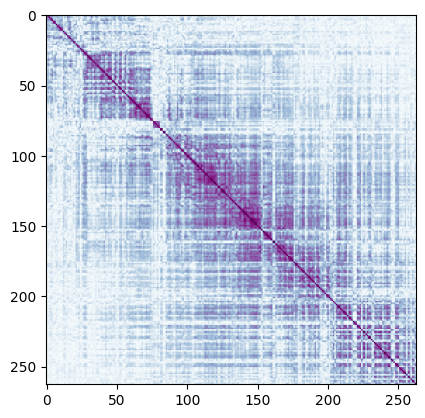